# HW1 Stat4ACSAI 

Group : **Benjamin Barda, Yusupha Juwara, Francesco Danese**


**[NOTE] On interactive plot** : The interactive plot from Exercise 2 works only in jupyter notebook (not jupyter lab). In order for the plot to display correctly it needs to be executed by hand (SHIFT+ENTER). I suggest running with 'run all' option and then rerun **ONLY** that cell by hand ... We have a non interactive plot in the notebook as well but we could not resist from making the plot interactive. 

## Libraries and python boring stuff

In [28]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider  
from matplotlib.patches import Ellipse
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d  



from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

try:
    import ipympl
except: 
    !pip install ipympl
    try: 
        import ipympl
    except:
        !conda install -y -c ipympl
        import ipympl

try :
    from yellowbrick.cluster import KElbowVisualizer 
except : 
    !conda install  -y -c districtdatalabs yellowbrick
    try:
        from yellowbrick.cluster import KElbowVisualize
    except: 
        !pip install -y yellowbrick
        from yellowbrick.cluster import KElbowVisualize

try : 
    import plotly.graph_objects as go
except : 
    #This might take some time if the library is not installed
    #It is indeed faster to open conda powershell and run the same command from there
    !conda install  -y -c  plotly plotly=5.6.0
    try:
        import plotly.graph_objects as go
    except : 
        !pip install plotly plotly=5.6.0

import warnings
warnings.filterwarnings('ignore')

## Exercise 1

Suppose that a student’s score X in ML is a number between 0 and 1, and that her score Z in Statistics is also a number between 0 and 1. Suppose further that in the population of all ACSAI students in the world (!), these scores are distributed according to the following joint pdf:

$$ f_{X, Z}(x, z) =
\begin{cases}
    8 \space (x \space z) && for & 0< z <x < 1 ) \\
    0 &&& otherwise
\end{cases}
$$

#### 1) **Check that $ f_{X,Z}(x, z) $ is a legit joint pdf and plot it in Python. What proportion of students obtain a score greater than 0.5 in Statistics, and what is the probability that a randomly selected student will have a Stat-score exactly equal to 0.5?**


### a). ```For a pdf ```$ f_{X, Z}(x, z)$ ```to be legit, there are 2 requirements: ```

- ### $f_{X, Z}(x, z) \geq 0 \implies 8(xz) \geq 0$ <br>
    Since 0<z<x<1, it cannot happen that $xz <0$. Thus, $8(xz) \geq 0$.

- ### ```The Normalization Property```

$$ 
\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f_{X, Z}(x, z) \partial z \partial x = 1 \\
\implies \int_{0}^{1} \int_{0}^{x} 8(x z) \partial z \partial x =  
\int_{0}^{1}  4x \left [z^2 \right]_{0}^{x} \partial x =
\int_{0}^{1} 4x^3 \partial x =
\left. x^4 \right|_{0}^{1} = 1
$$ 



## b). ```The plot of the PDF is as follows```

In [ ]:
def func(x,z):
  return 8*x*z if z < x else 0

x = np.linspace(start = .001,stop = 0.99, num = 300)
z = np.linspace(start = .001,stop = 0.99, num = 300)

x,z = np.meshgrid(x,z)

func = np.vectorize(func, otypes = [np.dtype(float)])

y = func(x,z)

#The graphical part
fig = go.Figure(data=[go.Surface(z=y, x = x, y = z )])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Distribution', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

### c). ```What proportion of students obtain a score greater than 0.5 in Statistic?```

To answer this: <br>
- we first obtain the pdf of Statistics alone - independent of the pdf of ML scores.

$$f_{Z} (z) = \int_{-\infty}^{\infty} f_{X, Z} (x, z) dx = \int_{z}^{1} 8xz dx = \left.  4x^2 z \right|_{z}^{1} = 4z - 4z^3 = 4z(1-z^2) $$

- Now we find the ```CDF``` of this newly-found pdf from 0.5 to 1. That is,

$$ P(Z > 0.5) = \int_{0.5}^{1} (4z-4z^3) dz = \left [2z^2 - z^4 \right]_{0.5}^{1} = (2-1) - (2*0.5^2 - 0.5^4) = 0.5625  \approx 0.56 $$ 

Note that we could have found the same with the joint pdf as follows:

$$ \int_{0.5}^1 \int_{z}^1 8xz dx dz = \left. \int_{0.5}^1 4x^2z \right|_{z}^1 dz = \int_{0.5}^1 4z-4z^3 dz= \dots \approx 0.56 $$

### Therefore, the proportion of students with marks greater than 0.5 in Statistics is approximately ``` 0.56  ```

### d). ```What is the probability that a randomly selected student will have a Stat-score exactly equal to 0.5?```

This answer is simply 0. Why? See the integral below

$$ P(Z=0.5) = \int_{0.5}^{0.5} (4z-4z^3) dz = [ 2z^2 - z^4]_{0.5}^{0.5} = 0  $$

#### 2) **Let W = log(Z) be the log-Stat score. Find and then plot its density in Python. What predicted value of W has the smallest mean squared error (MSE)? Find it analytically. Find also the median log-Stat score.**

### a). ``` Find the pdf of```  $ W= log(Z) $

- First of all, the limit of integration of W is (-$\infty$, 0) because Z goes from [0, 1]

- To find the pdf of $W = log(Z)$, we first find the cdf then we differentiate w.r.t W.

$$ F_{W}(w) = P(W \leq w) = P(log(Z) \leq w) = P(Z \leq e^w) = F_{Z}(e^w) $$

$$  f_{W}(w) = 
\begin{cases}
    \displaystyle \frac{\partial f}{\partial x} F_{Z}(e^w) = f_{Z}(e^w) \displaystyle \frac{\partial f}{\partial x} e^w = (4e^w-4e^{3w})e^w = 4e^{2w}-4e^{4w} && for -\infty<w<0 
\end{cases}  $$

### b). ```Plot W=log(Z)'s pdf in python```

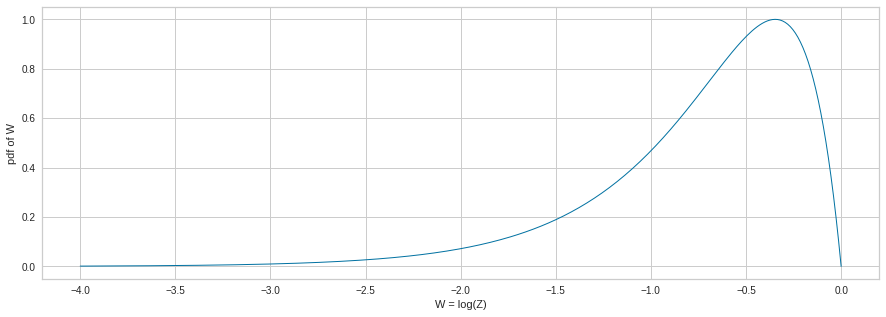

In [ ]:
from math import exp

W = np.linspace(-4, 0, 300)
pdf_w = [ [4*exp(2*w) - 4*exp(4*w)] for w in W ]

plt.figure(figsize=(15, 5))
plt.plot(W, pdf_w, lw=1, )
plt.xlabel("W = log(Z)"); plt.ylabel("pdf of W")
plt.show()

### c). ```What predicted value of W has the smallest mean squared error (MSE)? Find it analitically```

We would like to estimate W without observing anything. What would be our best estimate of W in that case?. The MSE is given by

$$ MSE = E[(\hat\theta_n - \theta)^2] = E[\hat\theta_n^2] - 2\theta E[\hat\theta_n] + \theta^2$$

The best estimate is where the error is minimum. The error is minimum when $\displaystyle\frac{\partial MSE}{\partial \hat\theta_n} = 0$.

Thus, $2E[\hat\theta_n] - 2\theta = 0 \implies \theta = E[\hat\theta_n]$  

We now find $E[\hat\theta_n]$,  where W = $\hat\theta_n$

$$
\int_{-\infty}^0 w (4e^{2w} - 4e^{4w}) dw = \underbrace{ w(2e^{2w}-e^{4w}) |_{-\infty}^0 }_{ 0} - \int_{-\infty}^0 (2e^{2w}-e^{4w}) dw = \int_{-\infty}^0 e^{4w}-2e^{2w} dw = \\
\left [ \frac{e^{4w}}{4} - e^{2w} \right]_{-\infty}^0 = \frac{1}{4} - 1 = - \frac{3}{4} 
$$


### 3) **Assuming a student got 0.8 in ML, find analytically the best MSE predictor for her Stat-score.**


From ```C``` above, if we have observed X=x, we can repeat the same argument. The only difference is that everything is conditioned on X=0.8. More specifically, the MSE is given by

$$ MSE = E[(Z- \theta)^2|X=0.8]  = E[Z^2|X=0.8] - 2\theta E[Z|X=0.8] + \theta^2$$

Again, we obtain a quadratic function of $\theta$, and by differentiation we obtain the MMSE estimate of Z given X=0.8 as

$$E[Z|X=0.8]$$  

Now let's find this conditional expectation.  

$$
E[Z|X=0.8] = \int_0^1 z f_{Z|X}(z|x) \partial z = \int_0^1 z \frac{f_{Z, X=0.8}(x, z)}{f_X (0.8)} \partial z = 
\int_0^1 z \frac{8(x=0.8)z}{4(x=0.8)^3} \partial z = \int_0^1 \frac{8z^2}{4(x=0.8)^2} \partial z =
 \int_0^1 \frac{25z^2}{8} \partial z   \\  
 = \left. \frac{25z^3}{8*3} \right|_0^1 = \frac{25}{24}
$$
Where $f_X(x) = \int_0^x 8xz dz = 4xz^2|_0^x = 4x^3$


## Exercise 2

We have the following probability density function: <br>
$$f(x|\alpha) = \frac{1}{2\pi}(1 + \alpha\cos(x)) \quad\quad for \space x\in [0,2\pi] \quad and \quad \alpha\in [-1/3,1/3]$$ <br>
<p> In order to check that is a valid PDF we must ensure 2 properties:<br><br></p>

* $f(x)$ is non-negative everywhere in the support $S$, that is, $f(x) \ge 0$ for all $x$ in $S$
* The are under the curve $S$ is 1, that is, $\int_{0}^{2\pi} f(x|\alpha)\ dx = 1$

<p><br>For the integral: <br><br></p>
$$\int\frac{1}{2\pi}(1 + \alpha\cos(x))\ dx \space=\space  \frac{1}{2\pi}\int (1 + \alpha\cos(x))\ dx
\space=\space \frac{1}{2\pi}\space [\space\int dx\ + \alpha \int \cos(x)\ dx\space] \space=\space
\frac{1}{2\pi}\space [x + \alpha\sin(x)]$$
<br>
<p> Let's evaluate at $|_{0}^{2\pi}$</p>

$$ \frac{1}{2\pi}\space [2\pi - 0] \space=\space \frac{2\pi}{2\pi} \space=\space 1$$
<p> <br>For the non-negativity i take the first derivative of the function and find the minimum(s): </p>
$for \space\alpha > 0 :$ <br>
$f^{'}(x) = - \frac{\alpha}{2\pi}\sin(x) > 0\quad =>\quad \sin(x) < 0\quad =>\quad \pi < x < 2\pi$ <br>
$f^{'}(x) = - \frac{\alpha}{2\pi}\sin(x) < 0 \quad =>\quad \sin(x) > 0 \quad =>\quad 0 > x > \pi$  <br>
<p> The derivative is > 0 when x > $\pi$ and < 0 when x <$\space\pi$ , therefore $\pi$ is a minimum<br>
Now let's check if the function at its minimum is negative. We proceed by contradiction supposing  $f$ is less than 0 at the minimum:<br><br>
$f(\pi) < 0 \quad =>\quad \frac{1-\alpha}{2\pi} < 0 \quad =>\quad 1 - \alpha < 0 \quad =>\quad \alpha > 1$ <br><br> And we see that at the minimum the function is < 0 only when $\alpha > 1$ , but $\alpha\in (0, 1/3]$ so $f(\pi) \ge 0 \space\forall \alpha$ <br>
Since $f(x)$ is always greater than zero at its minimum for any $\alpha$, it's always greater than zero in any point in $S$<br><br>
Based on the same reasoning, one can easily prove that even when $\alpha < 0$ and $\alpha = 0$ the function is non-negative everywhere.<br>
it's easy to check it, playing with the interactive graph below, you can change alpha as you prefer:<br><br>
</p> 

**IMPORTANT** : just run manually ONLY the cell below to see the interactive graph

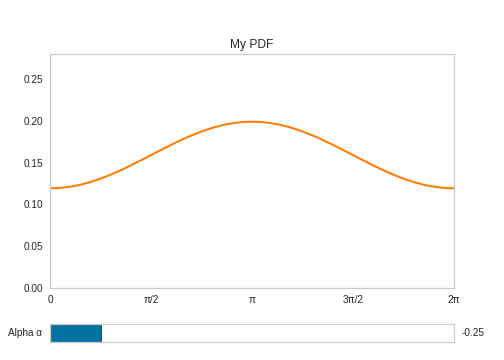

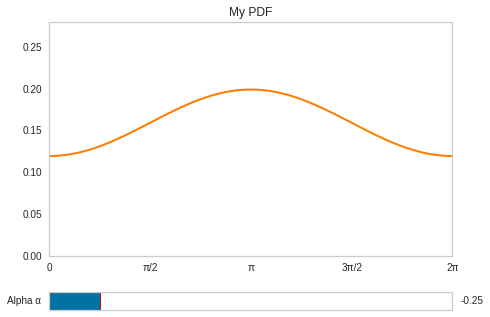

In [25]:
#PIP INSTALL IPYMPL
#Just run again ONLY this cell to see the interactive plot
%matplotlib widget

a_min = -1/3    # the minimial value of the paramater a
a_max = 1/3   # the maximal value of the paramater a
a_init = -1/4   # the value of the parameter a to be used initially, when the graph is created
x = np.linspace(0, 2*np.pi, 100) #Creating array x on it's domain [0, 2pi]

fig = plt.figure(figsize=(7,5))  #Starting figure where I'll insert the dynamic plot

def pdf(x, alpha):  #Probability density function f(x|a)
    return (1 + alpha*np.cos(x))/(2*np.pi)

# first we create the general layout of the figure
# with two axes objects: one for the plot of the function
# and the other for the slider
pdf_ax = plt.axes([0.1, 0.2, 0.8, 0.65])
slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])

# in pdf_ax we plot the function with the initial value of the parameter a
plt.axes(pdf_ax)       #select the function axes
plt.title('My PDF')    #add a title to the plot
pdf_plot, = plt.plot(x, pdf(x, a_init), color = plt.cm.hsv(1/12),lw=2)  #plotting the pdf with a red curve
plt.xlim(0, 2*np.pi)  #set range of x axis
plt.ylim(0, 0.28)     #set range of y axis
a_slider = Slider(slider_ax,         # the axes object containing the slider
                  'Alpha \u03B1',    # the name of the slider parameter
                  a_min,             # minimal value of the parameter
                  a_max,             # maximal value of the parameter
                  valinit=a_init     # initial value of the parameter
                 )

# Next we define a function that will be executed each time the value
# indicated by the slider changes. The variable of this function will
# be assigned to the value of the slider.
def update(a):
    pdf_plot.set_ydata(pdf(x,a))# set new y-coordinates of the plotted points
    pdf_plot.set_color(plt.cm.hsv(a+1/3))
    fig.canvas.draw_idle()          # redraw the plot
    
#deleting some plot functionalities and tools
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.resizable = False
fig.canvas.footer_visible = False
# the final step is to specify that the slider needs to execute the above function when its value changes 
a_slider.on_changed(update)
#plt.vlines(np.pi,0,0.3,linestyles='dotted')
plt.grid()
pi = np.pi
theta = np.arange(0, 2 * pi+pi/2, step=(pi / 2))
plt.xticks(theta,[ '0', 'π/2', 'π', '3π/2', '2π'])
plt.show()


<br><p>To find the method of moments estimator let's compute the mean of the distribution:<br><br>
    
$$\mu_{\chi} = \frac{1}{2\pi}\int_{0}^{2\pi}x(1+\alpha \cos(x))\space dx \space = \space \frac{1}{2\pi}\space(\int x\space dx + \alpha \int x \cos(x) dx \space) \space = \space \frac{1}{2\pi}\space(\frac{x^2}{2}+x\alpha sin(x) + \alpha cos(x)) $$<br>
Let's evaluate at $|_{0}^{2\pi}$
$$ \frac{4\pi^2 + 2\alpha}{4\pi} - \frac{\alpha}{2\pi} =  \frac{2\pi^2 +\alpha}{2\pi} - \frac{\alpha}{2\pi} = \frac{2\pi^2}{2\pi} = \pi $$ <br>
    
The mean is $\pi$ for all values of $\alpha$ so we have to compute the second moment to obtain an estimator:<br>
    
$$\mu_2 = \frac{1}{2\pi}\int_{0}^{2\pi}x^2(1+\alpha \cos(x))\space dx \space = \space \frac{1}{2\pi} [\int x^2 \space dx + \int \alpha x^2 \cos(x) \space dx] =$$$$ \frac{x^3}{3} + x^2\alpha \sin(x) + 2x\alpha \cos(x) - 2\alpha\sin(x)$$<br>
    
Let's evaluate at $|_{0}^{2\pi}$<br>
    
$$\frac{2\pi(4\pi^2 + 6\alpha)}{6\pi} - 0 = \frac{4\pi^2 +6\alpha}{3} = \frac{4}{3}\pi^2 + 2\alpha $$<br>
Therefore $\mu_2 = \frac{4}{3}\pi^2 + 2\alpha\space$ that leads to  $$\space\hat{\alpha} = \frac{1}{2}(\mu_2- \frac{4}{3}\pi^2)$$<br>
where $\mu_2$ means $\overline{x^2}$ that is the sample mean of the square of the observations.

In [ ]:
dataset = np.array([1.7, 5.1, 2.5, 5.6, 6, 0.3, 3.3, 5.7, 3.5, 2.8, 6, 2.8, 4.4, 3.7, 0.6, 5.7, 1.4, 0.2, 1.9,6])
#let's compute the sample mean of the square of the observations:
mu2 = (dataset**2).mean()                            
alpha = 1/2*(mu2 - 4*(np.pi)**2/3)      #using the formula for the estimate found above
print(f'Alpha = {alpha:.3f}')                   #rounding alpha to the third decimal digit and printing


Alpha = 1.356


Based on the small dataset, we found $\hat{\alpha} \approx 1.356$  

<br>
For the log-likelihood function we apply the natural logarithm to the likelihood function of our pdf:

$$\boldsymbol\ell (\alpha) = \ln\prod_{i=1}^{n} f(x_i|\alpha)) = \sum^{n}\ln(\frac{1}{2\pi}(1 + \alpha\cos(x_i))) = \sum^{n}\ln(\frac{1}{(2\pi)}) + \sum^{n}\ln(1 + \alpha\cos(x_i)) = $$ $$\ln(\frac{1}{(2\pi)^n}) + \sum^{n}\ln(1 + \alpha\cos(x_i))$$

We now proceed to implement it in python and plot it passing the vector $x_{20}$ 
   

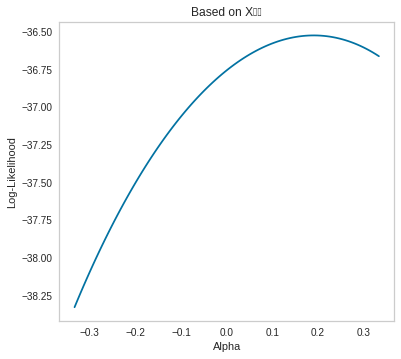

In [ ]:
%matplotlib inline
alphaAxis = np.linspace(-1/3,1/3,100)

def loglike(a,x):
    n = len(x)
    res1 = np.log(1/((2*np.pi)**n))
    res2 = 0
    for sample in x:
        log = np.log(1+a*np.cos(sample))
        res2 += log
    return -(res2 + res1)

y = - loglike(alphaAxis,dataset)
plt.figure(figsize=(6,5.5))
plt.plot(alphaAxis,y)
plt.xlabel('Alpha')
plt.ylabel('Log-Likelihood')
plt.title('Based on X\u2082\u2080')
plt.grid()
plt.show()

<br>
In order to find the Maximum Likelihood Estimator we need to determine the point at which $\ell (\alpha)$ is maximized.
To do this, we can differentiate the likelihood function and set it equal to 0:<br><br>
$$\frac{\partial \ell (\alpha)}{\partial \alpha} = \sum^{n}\frac{\cos(x_i)}{1 + \alpha\cos(x_i)} = 0$$
<br>
<p>Solve for $\alpha$ is pretty complicated, so let's python find the maximum for us using L-BFGS.<br><br>
$\quad$ First without gradient:</p><br>

Result : 0.19073064962283154
Total Evaluations: 8


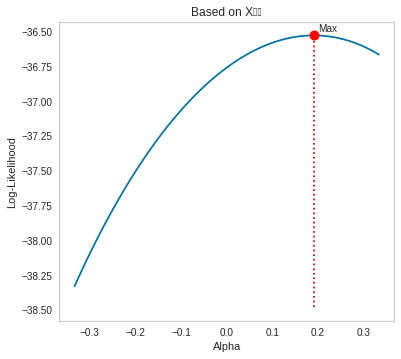

In [ ]:
%matplotlib inline
from scipy.optimize import minimize
from scipy.optimize import Bounds

myBounds = Bounds(-1/3,1/3)
#i choose 0.2 as initial guess because graphically it looks like the maximum should be close to that point
result = minimize(loglike, x0=[0.2],bounds = myBounds, args=dataset, method="L-BFGS-B" )

print(f'Result : %s' % result['x'][0])
print('Total Evaluations: %d' % result['nfev'])

MLE = result.x[0]
plt.figure(figsize=(6,5.5))
plt.plot(alphaAxis,y)
plt.plot(MLE, -loglike(MLE,dataset), marker="o", markersize=10, markeredgecolor="green", markerfacecolor="red")
plt.text(0.2, -36.5,'Max')
plt.xlabel('Alpha')
plt.ylabel('Log-Likelihood')
plt.vlines(MLE,-38.48,-loglike(MLE,dataset),linestyle='dotted',color='r')
plt.title('Based on X\u2082\u2080')
plt.grid()
plt.show()

<br>
Now with gradient, using our derivative previously found:
<br><br>

In [ ]:
def der(a,x):
    n = len(x)
    final = 0
    for sample in x:
        res1 = (np.cos(sample))/(1+a*np.cos(sample))
        final += res1
    return -final

In [ ]:
#i choose 0.2 as initial guess because graphically it looks like the maximum should be close to that point
result = minimize(loglike,x0=[0.2],bounds = myBounds,args=dataset, method="L-BFGS-B",jac=der)
print(f'Result : %s' % result['x'][0])
print('Total Evaluations: %d' % result['nfev'])

Result : 0.1907306229773464
Total Evaluations: 4


<br>
As we can see, passing also the gradient saves half of the evaluations. Math is good 🙃<br>
In both cases we have found $MLE \approx 0.1907$
<br><br>
Now let's proceed to plot the cdf of the raw data provided along with the cdf of the density using MLE and MoM estimates as $\alpha$
To do so we first find a generic cdf:<br><br>
$$\int_{0}^{k}\frac{1}{2\pi}(1 + \alpha\cos(x))\ dx \space=\space  \frac{1}{2\pi}\int_{0}^{k} (1 + \alpha\cos(x))\ dx
\space=\space \frac{1}{2\pi}\space [\space\int_{0}^{k} dx\ + \alpha \int_{0}^{k} \cos(x)\ dx\space] \space=\space\frac{1}{2\pi}\space [k - 0 + \alpha\sin(k) - 0]\space=\space\frac{1}{2\pi}\space [k + \alpha\sin(k)]$$<br><br>
And then plot this cdf using $\alpha =$ 0.1907 (MLE) and $\alpha = $1.356 (MoM)

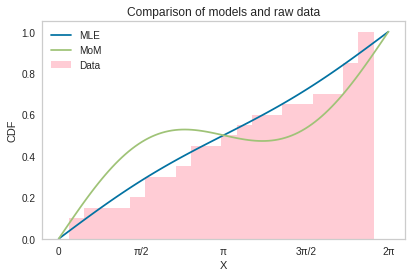

In [ ]:
%matplotlib inline
from scipy import stats

plt.figure(figsize=(6.5,4))
plt.hist(dataset,density=True,cumulative=True,bins=len(dataset), label='Data',alpha=0.8, color='pink')
x = np.linspace(0, 2*np.pi, 100)

def cdf(k,a):
    return 1/(2*np.pi) * (k + a*np.sin(k))

lineMle, = plt.plot(x,cdf(x,MLE),label='MLE')
lineMoM = plt.plot(x,cdf(x,alpha),label='MoM')
plt.grid()
plt.legend()
plt.xticks(theta,[ '0', 'π/2', 'π', '3π/2', '2π'])
plt.title("Comparison of models and raw data")
plt.xlabel('X')
plt.ylabel('CDF')
pi = np.pi
theta = np.arange(0, 2 * pi+pi/2, step=(pi / 2))

 Based on this graph, we could say the MLE fits pretty well, on the other hand MoM shows clearly some lack-of-fit. I think this depends on the fact that the sample size of the data provided was quite small (20 elements) and hence it affected the precision of MoM estimator.

## Exercise number 3

### Helper Functions

In [29]:
# Sorry for stealing this professor :) !!!

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    # ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

### [3.1] Data cleaning and selection
**Import the data, and look at the automakers listed in the variable make. Select a large one and obtain a derived dataset
by filtering out all the others.**

In [30]:
pathToCsv = 'cars2021.csv'

df = pd.read_csv(pathToCsv)
# Visualize first 5 rows of the dataframe
df.head() 

FileNotFoundError: ignored

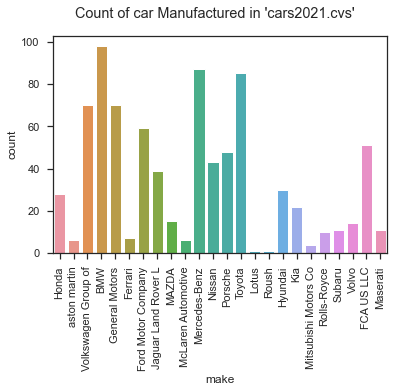

In [ ]:
sns.set_theme(style='ticks')

# Plot the count based on make
sns.countplot(data = df, x = 'make', orient='v')

# Rotate x-axis labels to make them redable
plt.xticks(rotation=90)
plt.suptitle("Count of car Manufactured in 'cars2021.cvs'")
plt.show()

**I am more intrested in the unique values not really on the raw count ... so let's drop duplicates**

In [27]:
# Dropping duplicate (numerical rows)
dropped = df.drop_duplicates(['make', 'displacement', 'number_cyl', 'number_gears', 'city_mpg', 'hwy_mpg']) 

# Plot the count based on make
sns.countplot(data = dropped, x = 'make', orient='v')

# Rotate x-axis labels to make them redable
plt.xticks(rotation=90)
plt.suptitle("Count of car Manufactured in 'cars2021.cvs' without duplicates")
plt.show()

NameError: ignored

**and check for Null Values**

In [ ]:
# For each column count and sum possible presence of null values
df.isna().sum()

make            0
model           0
displacement    0
number_cyl      0
number_gears    0
city_mpg        0
hwy_mpg         0
dtype: int64

**We have two choices at this point: TOYOTA or Mercedes-Benz.** 

**For the sake of this exercise let us look at the biggest one Toyota.** 

In [ ]:
# Notice we slice from the original dataset not the reduced one 
toyota = df[df['make'] == 'Toyota'] 

# Drop the make column since they are all Toyota by now
toyota.drop(['make'], inplace = True, axis = 1)
toyota.head()

,model,displacement,number_cyl,number_gears,city_mpg,hwy_mpg
66,LC 500 CONVERTIBLE,5.0,8,10,15,25
132,LC 500,5.0,8,10,16,25
133,LC 500h,3.5,6,10,26,34
134,RC 300,2.0,4,8,21,31
135,RC 300 AWD,3.5,6,6,19,26


### [3.2 / 3] Selection and plot

**2. Look at the other five numeric variables available, and pick the two that you feel are the most relevant to perform
the task described. Briefly explain your choice**

**3.  Check the presence of missing values, filter them out and then visualize and numerically summarize the distribution of
the two variables selected**

In [ ]:
# Pd function that return some basic information on each numerical feature.
toyota.describe()

,displacement,number_cyl,number_gears,city_mpg,hwy_mpg
count,85.000000,85.000000,85.000000,85.000000,85.000000
mean,3.074118,5.176471,6.929412,26.517647,31.729412
std,1.064710,1.390242,2.170079,10.544251,8.443634
min,1.800000,4.000000,1.000000,12.000000,16.000000
25%,2.500000,4.000000,6.000000,19.000000,26.000000
50%,2.500000,4.000000,8.000000,23.000000,31.000000
75%,3.500000,6.000000,8.000000,31.000000,37.000000
max,5.700000,8.000000,10.000000,58.000000,53.000000


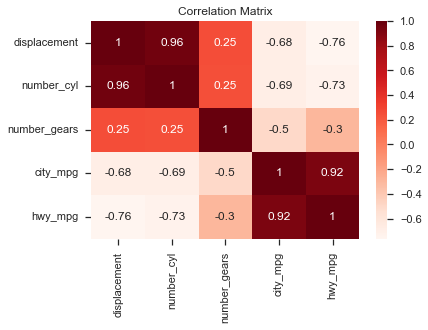

In [ ]:
# Plot the correlation matrix ... heatmap to visualize better
sns.heatmap(toyota.corr(), annot=True, cmap=plt.cm.Reds)
plt.title("Correlation Matrix")
plt.show()

* Very strong correlation between `hwy_mpg` and `city_mpg`
* Very strong correlation between `number_cyl` and `displacement`

In [ ]:
# Look at the variance
toyota.var(numeric_only=True)

displacement      1.133608
number_cyl        1.932773
number_gears      4.709244
city_mpg        111.181232
hwy_mpg          71.294958
dtype: float64

I suspect that `number_gears` would not be very informative compared to engine size (`displacement`, `number_cyl`) and consumption (`city_mpg`, `hwy_mpg`). 

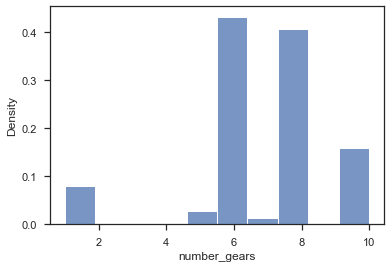

In [ ]:
# Density histogram plot
sns.histplot(data = toyota, x = 'number_gears', stat = 'density')
plt.show()

In fact as we can see from it's density as expected most of the cars have either 6 or 8 gears so i would discard this column as a candidate.

Also I would avoid choosing two higly correlated features. So i would procede choosing one from the `'consumption'` category and one from the `engine size` group.

In [ ]:
# For each feature the count of unique values
toyota.nunique()

model           85
displacement    10
number_cyl       3
number_gears     6
city_mpg        30
hwy_mpg         29
dtype: int64

Following my reasoning i would pick the attributes with the most information, that is `city_mpg` and `displacement` ... Let's plot their densities

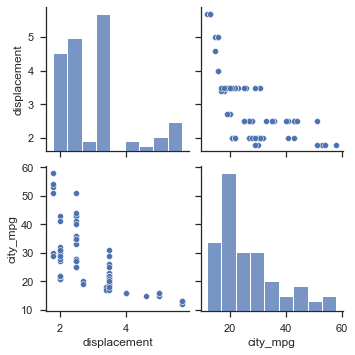

In [ ]:
# slicing based on column name rather than index
fin_pair = toyota.loc[:, ['displacement', 'city_mpg']].copy()

# Usefull sns plot function to quickly plot pair of features in the dataframe
sns.pairplot(fin_pair)
plt.show()

**I am happy with my choice so we can procede with the analysis**

### [3.4] MoG and Cross Validation
**4. Cluster the data using MoG by selecting the number of components via a 70%-30% sample-splitting scheme that you
implement from scratch (just the evaluation, for the fit use of course scikit-learn). Compare the results with the
AIC selection (again, use the implementation in scikit-learn). Beside the (possibly different) optimal number of
components, can you figure out a way to evaluate some form of “agreement” between the two clusterizations obtained?
In general, do you think that one is any better than the other? Explain, possibly with relevant plots or stats.**

In [ ]:
# Splitting whole dataset in trainset and validation set (70% - 30%)
fin_train, fin_val = train_test_split(fin_pair, test_size = .3, random_state=97)
print(f'Shape of Train set : {fin_train.shape}\nShape of Validation set : {fin_val.shape}')

Shape of Train set : (59, 2)
Shape of Validation set : (26, 2)


The question is how many components should our gaussian mixture have ? we use cross validation to check. 

In [ ]:
n_components = np.arange(1,6)

# Fit the MoG's  with n components to the train set
models = [mixture.GaussianMixture(n_components=n, covariance_type='full', random_state = 0).fit(fin_train) for n in n_components] # Fit the MoG's to the train set with components from 1 to 15

In [ ]:
def crossValidation(models, valSet, kfold = False, K = None) : 
  '''
  param: 
    model    : 
    valSet   : set to validate on : pd.DataFrame
    kfold    : if true merge back the two set then use kfold with K = K : bool
    k        : K to use if Kfold = True : int_
  return: 
    [val array]  
  '''

  res = []

  N = valSet.shape[0]

  for model in models : 
    logprob = model.score_samples(valSet)
    s =  - np.sum(logprob)
    s = s / N 
    res.append(s)
  return res

res = crossValidation(models, fin_val)

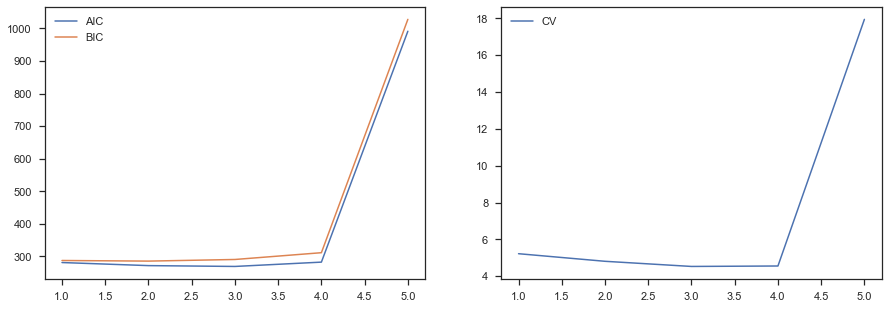

In [ ]:
fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

# Akaike information criterion
sns.lineplot(x = n_components, y = [m.aic(fin_val) for m in models], label = 'AIC', ax = ax[0])

# Bayesian information criterion
sns.lineplot(x = n_components, y = [m.bic(fin_val) for m in models], label = 'BIC', ax = ax[0])

# Cross Validation Algorithm
sns.lineplot(x = n_components, y = res, label = 'CV', ax = ax[1])
plt.legend()
plt.show()

The lower is better and is it easy to see that 4 is the best choice

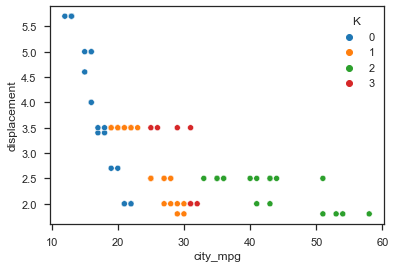

In [ ]:
# Choose the model with 4 components
model = models[3]

# Predict and plot with selected model
mog_clus = fin_pair.copy()
mog_clus['K'] = model.predict(mog_clus)
sns.scatterplot(data=mog_clus, y = 'displacement', x = 'city_mpg', hue = 'K', palette = 'tab10')

plt.show()

**We can see that the model we chose really do not find relevant the displacement. This might be because of the very big diffrence scale of the two**

So maybe scaling might be an option

In [ ]:
# Scale to mean=0 and std=1
scaler = StandardScaler()
scaled = scaler.fit_transform(fin_pair)

# Put it all back into a pd dataframe
scaled = pd.DataFrame(scaled, columns=['displacement', 'city_mpg']) #Put it all back into a pd dataframe

# Splitting whole dataset in trainset and validation set (70% - 30%)
scaled_train, scaled_val = train_test_split(scaled, test_size = .3, random_state=97) 

In [ ]:
n_components = np.arange(1,6)

# Fit the MoG's  with n components to the train set
models = [mixture.GaussianMixture(n_components=n, covariance_type='full', random_state = 0).fit(scaled_train) for n in n_components] # Fit the MoG's to the train set with components from 1 to 15

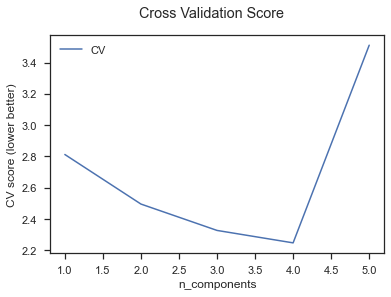

In [ ]:
# Cross Validation and plot
res = crossValidation(models, scaled_val)
sns.lineplot(x = n_components, y = res, label = 'CV')
plt.suptitle('Cross Validation Score')
plt.xlabel('n_components')
plt.ylabel('CV score (lower better)')
plt.show()

In [ ]:
#The model with 4 components
model = models[3] 
sc_clus = scaled.copy()

# Predict with selected model
sc_clus['K'] = model.predict(sc_clus)

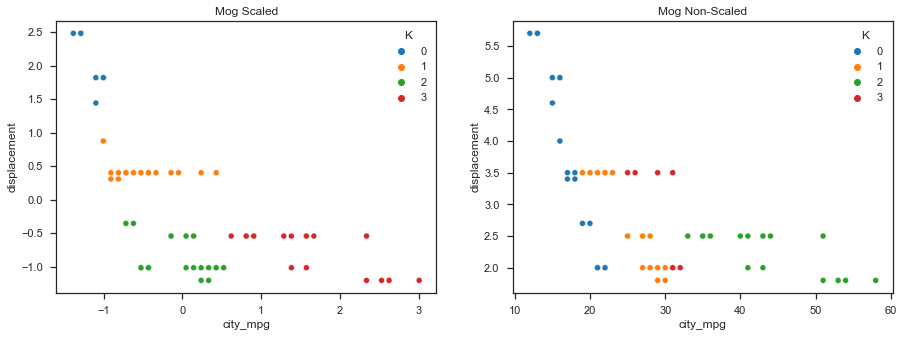

In [ ]:
#Plot comparison between scaled and Non-Scaled
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].title.set_text('Mog Scaled')
ax[1].title.set_text('Mog Non-Scaled')

sns.scatterplot(data = sc_clus, y = 'displacement', x = 'city_mpg', hue = 'K', palette = 'tab10', ax = ax[0])
sns.scatterplot(data=  mog_clus, y = 'displacement', x = 'city_mpg', hue = 'K', palette = 'tab10', ax = ax[1])
plt.show()

**As we can see a much more reasonable clustering, since `city_mpg` do not dominate the other feature**

### [3.5] K-MEANS
**5. Repeat the analysis using k-mean by selecting k via the Elbow method. Compare with the previous results.**

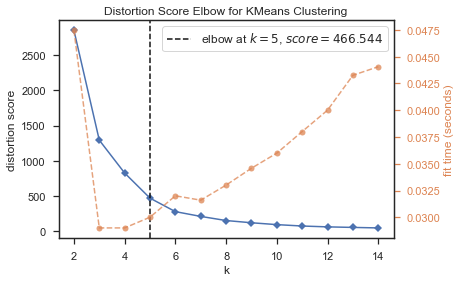

In [ ]:
# Kmean constructor
mod = KMeans()
visualizer = KElbowVisualizer(mod, k=(2,15))

# Fit visualizer on non scaled dataframe
visualizer.fit(fin_pair) 
visualizer.show()        

plt.show()

In [ ]:
# Initialize KMEAN clustering with k centroids
km = KMeans(n_clusters=5)

# Predict using k centroids
y_km = km.fit_predict(fin_pair)


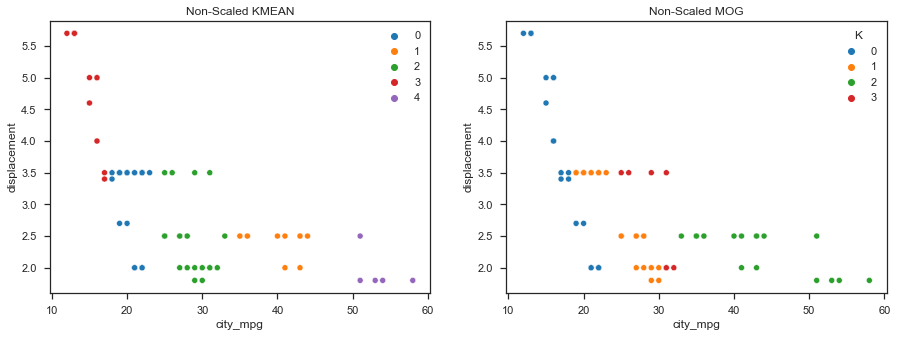

In [ ]:
#Plot comparison between Non-Scaled KMEAN and Non-Scaled MoG
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(15,5))

sns.scatterplot(data=fin_pair, y = 'displacement', x = 'city_mpg', hue = y_km, palette = 'tab10', ax = ax[0])
sns.scatterplot(data=  mog_clus, y = 'displacement', x = 'city_mpg', hue = 'K', palette = 'tab10', ax = ax[1])
ax[0].title.set_text('Non-Scaled KMEAN')
ax[1].title.set_text('Non-Scaled MOG')

plt.show()

Let's try to do it on the scaled dataset

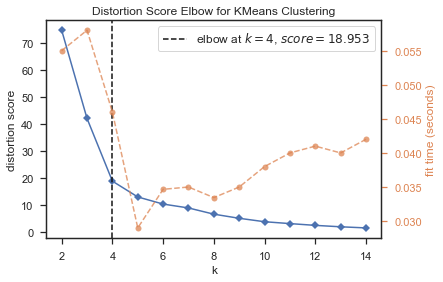

In [ ]:
# Kmean constructor
mod = KMeans()
visualizer = KElbowVisualizer(mod, k=(2,15))

# Fit visualizer on scaled dataframe
visualizer.fit(scaled) 
visualizer.show()        

plt.show()

In [ ]:
km = KMeans(n_clusters=4)

# Predict using k centroids
y_km = km.fit_predict(scaled)

NameError: ignored

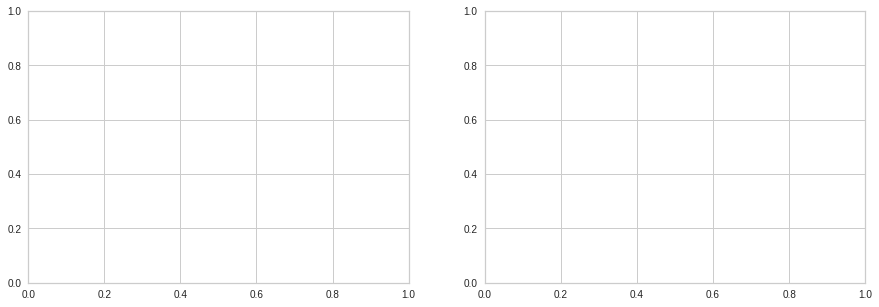

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(15,5))

sns.scatterplot(data=scaled, y = 'displacement', x = 'city_mpg', hue = y_km, palette = 'tab10', ax = ax[0])
ax[0].title.set_text('KMEAN scaled')
ax[1].title.set_text('MoG Scaled')
sns.scatterplot(data = sc_clus, y = 'displacement', x = 'city_mpg', hue = 'K', palette = 'tab10', ax = ax[1])
plt.show()

### Considerations 

> In my opinion just looking at two features out of five of one single manufacturer it is indeed impossible to infer the type of vehicle. In fact as an example think of an hybrid car ... **Assuming the data is correct** an hybrid car would have a very high `city_mpg` (low consumption) but a very low `highway_mpg`, because during a trip on an highway the electric engine would not be engaged at all (almost).


> One way to get around this problem would be to repeat the analysis unifying the consumption columns (`highway_mpg`,`city_mpg`),According to the report given in the exercise we can compute the overall consumption by considering a weighted sum of the two (45% for the first and 55% for the latter). 


> We can think at the clusters as follow 
>> 1. High Consumption Big engine : Those could be SUVs
>> 2. high Consumption medium sized engine : those could be sports car
>> 3. Moderate Consumption small engine : We can think of family cars
>> 4. low consumption small engine : city cars / hybrid





### Let's elevate to more dimensions

Having seen the improvement on the scaled dataset we will work directly on the scaled one

In [ ]:
model = toyota.pop('model')

In [ ]:
scaler = StandardScaler()
tyt_scaled = scaler.fit_transform(toyota)

In [ ]:
tyt_train, tyt_val = train_test_split(tyt_scaled, test_size=.30, random_state = 55)

n_components = np.arange(1,10)
models = [mixture.GaussianMixture(n_components=n, covariance_type='full', random_state = 0).fit(tyt_train) for n in n_components] # Fit the MoG's to the train set with components from 1 to 15
res = crossValidation(models, tyt_train)

NameError: ignored

NameError: ignored

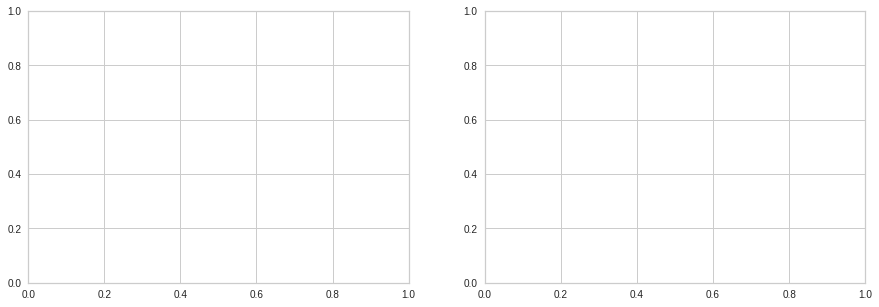

In [ ]:
fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

# Akaike information criterion
sns.lineplot(x = n_components, y = [m.aic(tyt_scaled) for m in models], label = 'AIC', ax = ax[0])

# Bayesian information criterion
sns.lineplot(x = n_components, y = [m.bic(tyt_scaled) for m in models], label = 'BIC', ax = ax[0])

# Cross Validation Algorithm
sns.lineplot(x = n_components, y = res, label = 'CV', ax = ax[1])
plt.show()

We can see that CrossValidation suggest us to use 5 components while AIC and BIC clearly prefer 4

In [ ]:
five_c = models[4]
four_c = models[3]
tyt_scaled = pd.DataFrame(tyt_scaled, columns = ['displacement',	'number_cyl',	'number_gears',	'city_mpg',	'hwy_mpg'])
tyt_scaled['Y5'] = five_c.predict(tyt_scaled)

NameError: ignored

In [ ]:
import plotly.express as px

X = tyt_scaled['displacement']
Y = tyt_scaled['city_mpg']
Z = tyt_scaled['number_gears']
H = tyt_scaled['Y5']
fig = px.scatter_3d(tyt_scaled, x = X, y = Y, z = Z, color = H,color_discrete_sequence = True)
fig.update_traces(marker_size = 5)
fig.show()

NameError: ignored


***We can see here that even if we plot in just 3 out 5 dimensions the clusters are close to each other. I believe that is due to the high correlation between the features that I already explained above***

#### Final considerations

Apart from the obvious lack of the clustering in 5 dimensions using Kmeans, i believe that many improvement can be made to our analysis. 

First we could check wether the data provided is corrext by matching it against the official dataset provided in the paper. 

Secondly we could try to create labels based on clusters and model name. We noticed great similarity in the model name. The first word of each model is common to many others. We could try to predict the model of the car knowing the maker of it; Or with a more expensive analysis we could research to which vehicle category each model belongs. 

